# scoring ilir and screening PSSMs

Test sets: 7mers
- screening - [FWY]xx[LVI]
- screening - [FWY]xx[FWY]
- lir central - (not the augmented set)


PSSM foregrounds:
- ilir
- screening data:
    - different z-score ranges

PSSM background:
- proteome

psuedocounts:
- 1.0

In [1]:
from lir_proteome_screen_pssm import environment as env
from lir_proteome_screen_pssm import pssms
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt

plt.style.use("custom_standard")
plt.style.use("custom_small")
import seaborn as sns
import lir_proteome_screen_pssm.sequence_utils as seqtools
import copy
from pathlib import Path
import re
# import umap
# from sklearn.preprocessing import OneHotEncoder
import lir_proteome_screen_pssm.data_loaders as dl
import lir_proteome_screen_pssm.stats as stats

# %load_ext autoreload
# %autoreload 2

In [2]:
k = set(dl.PROCESSED_SEQUENCE_TABLES.ilir_binders["7mer"].to_list())
x = set(dl.PROCESSED_SEQUENCE_TABLES.screen_binders["7mer"].to_list())
y = set(dl.PROCESSED_SEQUENCE_TABLES.screen_nonbinders["7mer"].to_list())
z = set(dl.TEST_SETS.lir_central["7mer"].to_list())
print(k.intersection(x))
print(k.intersection(y))
print(k.intersection(z))
print(len(k.intersection(x)))
print(len(k.intersection(y)))
print(len(k.intersection(z)))
print(x.intersection(y))
print(x.intersection(k))
print(y.intersection(k))

set()
set()
set()
0
0
0
set()
set()
set()


In [3]:
plt.rcParams.update({"font.size": 14})

In [4]:
def _make_test_set(binders_df, nonbinders_df, lir_type, test_size=50, random_seed=42):
    test_binders = (
        binders_df[binders_df["lir_type"] == lir_type]
        .sample(n=test_size, random_state=random_seed, replace=False)
        .copy()
    )
    test_nonbinders = (
        nonbinders_df[nonbinders_df["lir_type"] == lir_type]
        .sample(n=test_size, random_state=random_seed, replace=False)
        .copy()
    )
    return pd.concat([test_binders, test_nonbinders], ignore_index=True)


def make_screen_sets(
    screen_binders_df: pd.DataFrame,
    screen_nonbinders_df: pd.DataFrame,
    old_regex: str = "...[FWY]..[LVI]",
    new_regex: str = "...[FWY]..[WFY]",
    old_regex_test_size: int = 40,
    new_regex_test_size: int = 30,
    random_seed: int = 42,
):
    """
    parameters
    ----------
    screen_binders_df : pd.DataFrame
        DataFrame containing binder sequences with a column "7mer" for the 7-mer sequence.
    screen_nonbinders_df : pd.DataFrame
        DataFrame containing non-binder sequences with a column "7mer" for the 7-mer sequence.
    old_regex : str
        Regular expression for the old LIR type (default: "...[FWY]..[LVI]").
    new_regex : str
        Regular expression for the new LIR type (default: "...[FWY]..[WFY]").
    old_regex_test_size : int
        Number of sequences to sample for the old LIR type test set (default: 40).
    new_regex_test_size : int
        Number of sequences to sample for the new LIR type test set (default: 30).
    random_seed : int
        Random seed for reproducibility (default: 42).
    
    returns
    -------
    oldlir_test : pd.DataFrame
        DataFrame containing the test set for the old LIR type.
    newlir_test : pd.DataFrame
        DataFrame containing the test set for the new LIR type.
    binder_training_set : pd.DataFrame
        DataFrame containing the training set for binders, excluding the test sequences from both tests.
    """
    oldlir_test = _make_test_set(
        screen_binders_df,
        screen_nonbinders_df,
        old_regex,
        test_size=old_regex_test_size,
        random_seed=random_seed,
    )
    newlir_test = _make_test_set(
        screen_binders_df,
        screen_nonbinders_df,
        new_regex,
        test_size=new_regex_test_size,
        random_seed=random_seed,
    )
    test_7mers = oldlir_test["7mer"].tolist() + newlir_test["7mer"].tolist()
    binder_training_set = screen_binders_df[~screen_binders_df["7mer"].isin(test_7mers)].copy()
    return oldlir_test, newlir_test, binder_training_set    

In [5]:
def plot_test_set(test_sets: dict[str, pd.DataFrame]):
    n_plots = len(test_sets)
    fig, axes = plt.subplots(
        nrows=n_plots,
        ncols=1,
        figsize=(8, 2 * n_plots),
        sharex=True,
    )
    for ax, (name, testset) in zip(axes, test_sets.items()):
        ax.set_title(name)
        pssms.plot_logo(
            pssms.seqlist_2_counts_matrix(testset[testset['true label']==1]["7mer"].to_list()),
            ax=ax,
        )
        ax.set_ylabel("count")
    axes[-1].set_xlabel("Position")
    plt.tight_layout()
    return fig, axes

In [6]:
def plot_foregrounds(foregrounds: dict[str, pd.DataFrame]):
    n_plots = len(foregrounds)
    fig, axes = plt.subplots(
        nrows=n_plots,
        ncols=1,
        figsize=(8, 2 * n_plots),
        sharex=True,
    )
    for ax, (name, foreground) in zip(axes, foregrounds.items()):
        ax.set_title(name)
        pssms.plot_logo(
            foreground,
            ax=ax,
        )
        ax.set_ylabel("count")
    axes[-1].set_xlabel("Position")
    plt.tight_layout()
    return fig, axes

In [7]:
def plot_pssms(pssms: dict[str, pd.DataFrame]):
    fig, axes = plt.subplots(
        nrows=len(pssm_dict),
        ncols=1,
        figsize=(5, 2 * len(pssm_dict)),
        sharex=True,
    )
    for ax, (name, pssm) in zip(axes, pssm_dict.items()):
        pssms.plot_logo(pssm, title=name, ax=ax)
        ax.set_title(name)
    plt.tight_layout()
    return fig, axes

In [8]:
def plot_auc_results(auc_results_df: pd.DataFrame):
    order = [
        "screen",
        "screen: 1.7 <= z-score < 2.0",
        "screen: 2.0 <= z-score < 3.0",
        "screen: 3.0 <= z-score < 4.2",
        "screen: xxx[FWY]xx[WFY]",
        "screen: xxx[FWY]xx[LVI]",
        "ilir",
    ]
    g = sns.catplot(
        data=auc_results_df,
        x="foreground",
        y="auROC",
        col="test set",
        kind="bar",
        sharey=True,
        height=4,
        aspect=1.2,
        order=order,
    )
    g.set_xticklabels(rotation=90)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Foreground", "auROC")
    for ax in g.axes.flatten():
        for spine in ax.spines.values():
            spine.set_visible(True)

In [9]:
def plot_auc_results_replicates(auc_results_df: pd.DataFrame, order: list[str] | None = None):
    if order is None:
        order = [
            "screen",
            "screen: 1.7 <= z-score < 2.0",
            "screen: 2.0 <= z-score < 3.0",
            "screen: 3.0 <= z-score < 4.2",
            "screen: xxx[FWY]xx[WFY]",
            "screen: xxx[FWY]xx[LVI]",
            "ilir",
            "screen: (cheating)",
            "screen: xxx[FWY]xx[WFY] (cheating)",
        ]
    g = sns.catplot(
        data=auc_results_df,
        x="foreground",
        y="auROC",
        col="test set",
        kind="boxen",
        sharey=True,
        height=4,
        aspect=1.2,
        order=order,
    )
    g.set_xticklabels(rotation=90)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Foreground", "auROC")
    for ax in g.axes.flatten():
        for spine in ax.spines.values():
            spine.set_visible(True)

In [10]:
def score_test_sets_with_pssms(test_sets: dict[str, pd.DataFrame], pssm_dict: dict[str, pd.DataFrame]):
    auc_results = []
    for foreground, pssm in pssm_dict.items():
        for test_set_name, test_set in test_sets.items():
            temp_df = test_set.copy()
            temp_df["pssm_score"] = temp_df["7mer"].apply(
                pssms.PSSM_score_sequence, PSSM=pssm
            )
            auroc = stats.df_2_roc_auc(temp_df, "true label", "pssm_score")
            auc_results.append(
                {
                    "foreground": foreground,
                    "test set": test_set_name,
                    "auROC": auroc,
                }
            )
    return pd.DataFrame(auc_results)

In [11]:
def driver(
    pseudo_count=1,
    background=dl.BGFREQS.proteome,
    z_score_ranges=None,
    old_regex_test_size=40,
    new_regex_test_size=30,
    random_seed=55,
):
    if z_score_ranges is None:
        z_score_ranges = [
            [1.7, 2.0],
            [2.0, 3.0],
            [3.0, 4.2],
        ]
    oldlirtest, newlirtest, screen_training = make_screen_sets(
        screen_binders_df=dl.PROCESSED_SEQUENCE_TABLES.screen_binders,
        screen_nonbinders_df=dl.PROCESSED_SEQUENCE_TABLES.screen_nonbinders,
        old_regex_test_size=old_regex_test_size,
        new_regex_test_size=new_regex_test_size,
        random_seed=random_seed,
    )
    test_sets = {
        "lir_central": dl.TEST_SETS.lir_central.copy(),
        "[FWY]xx[LVI]": oldlirtest.copy(),
        "[FWY]xx[WFY]": newlirtest.copy(),
    }
    foregrounds = {
        "ilir": dl.PROCESSED_SEQUENCE_TABLES.ilir_binders["7mer"].to_list(),
        "screen": screen_training["7mer"].to_list(),
    }
    for z_score_range in z_score_ranges:
        temp = screen_training[
            (screen_training["avg_z_score"] >= z_score_range[0])
            & (screen_training["avg_z_score"] < z_score_range[1])
        ].copy()
        foregrounds[f"screen: {z_score_range[0]} <= z-score < {z_score_range[1]}"] = (
            temp["7mer"].to_list()
        )
    foregrounds["screen: xxx[FWY]xx[WFY]"] = screen_training[
        screen_training["lir_type"] == "...[FWY]..[WFY]"
    ]["7mer"].to_list()
    foregrounds["screen: xxx[FWY]xx[LVI]"] = screen_training[
        screen_training["lir_type"] == "...[FWY]..[LVI]"
    ]["7mer"].to_list()
    foregrounds["screen: (cheating)"] = dl.PROCESSED_SEQUENCE_TABLES.screen_binders.copy()["7mer"].to_list()
    temp = dl.PROCESSED_SEQUENCE_TABLES.screen_binders.copy()
    foregrounds["screen: xxx[FWY]xx[WFY] (cheating)"] = temp[temp["lir_type"] == "...[FWY]..[WFY]"]["7mer"].to_list()
    for k, v in foregrounds.items():
        foregrounds[k] = pssms.seqlist_2_counts_matrix(v, pseudocount=pseudo_count)
    pssm_dict = {}
    for name, foreground in foregrounds.items():
        pssm = pssms.make_pssm(
            df_counts=foreground,
            bg=background,
        )
        pssm_dict[name] = pssm
    auc_results = score_test_sets_with_pssms(test_sets, pssm_dict)
    return test_sets, foregrounds, pssm_dict, auc_results

In [12]:
class PssmTestScores:

    def __init__(
        self, 
        test_sets: dict[str, pd.DataFrame], 
        foregrounds: dict[str, pd.DataFrame],
        pssm_dict: dict[str, pd.DataFrame], 
        auc_results: pd.DataFrame
    ):  
        self.test_sets = test_sets
        self.foregrounds = foregrounds
        self.pssm_dict = pssm_dict
        self.auc_results = auc_results

In [13]:
auc_roc_replicates = []
seed = 55
for i in range(100):
    r = PssmTestScores(*driver(
        pseudo_count=1,
        background=dl.BGFREQS.proteome,
        z_score_ranges=None,
        old_regex_test_size=40,
        new_regex_test_size=30,
        random_seed=seed,
    ))
    seed += 1
    auc_roc_replicates.append(r.auc_results)
auc_roc_replicates_df = pd.concat(auc_roc_replicates, ignore_index=True)

In [14]:
# get the mean and standard deviation of the auROC for each foreground and test set
auc_roc_mean = auc_roc_replicates_df.groupby(["foreground", "test set"]).mean().reset_index()
auc_roc_std = auc_roc_replicates_df.groupby(["foreground", "test set"]).std().reset_index()
auc_roc_mean=auc_roc_mean.rename(columns={"auROC": "mean auROC"})
auc_roc_std = auc_roc_std.rename(columns={"auROC": "std auROC"})
auc_roc_results = pd.merge(auc_roc_mean, auc_roc_std, on=["foreground", "test set"])

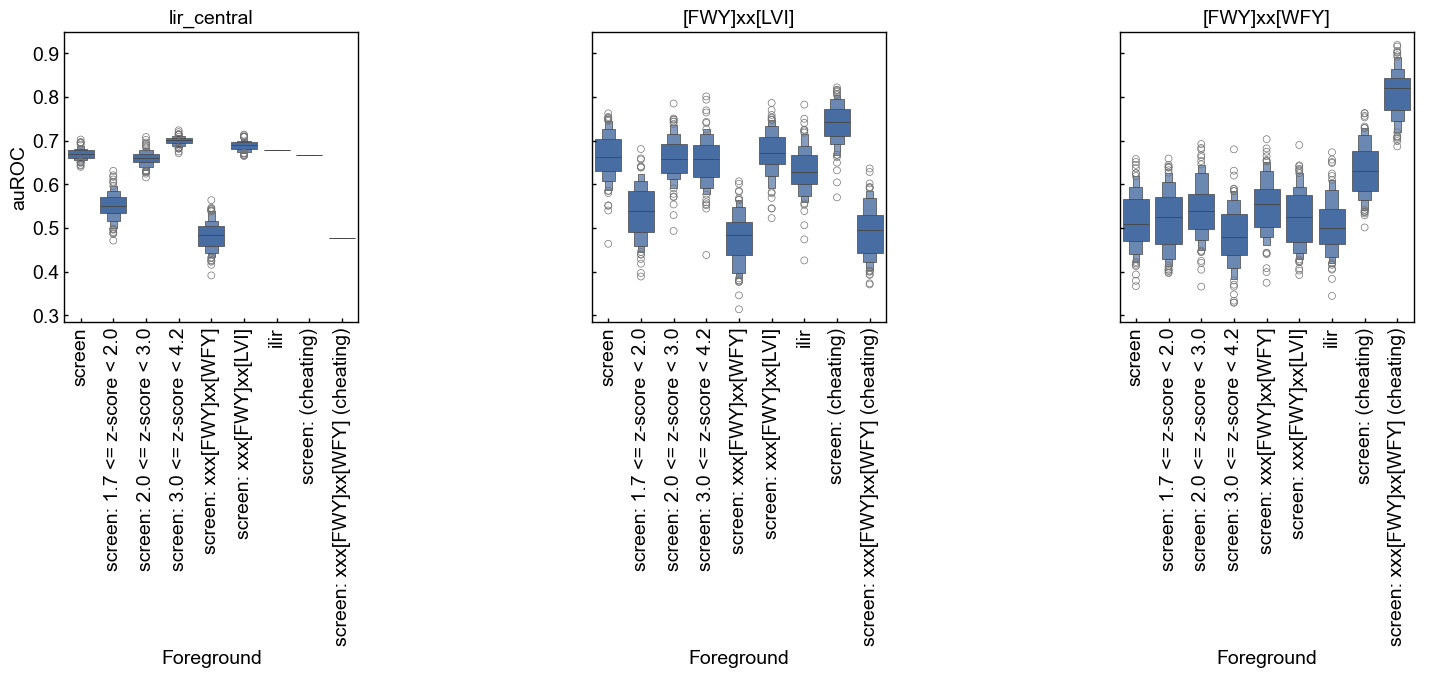

In [15]:
plot_auc_results_replicates(auc_roc_replicates_df)

In [16]:
auc_roc_replicates = []
seed = 55
for i in range(100):
    r = PssmTestScores(*driver(
        pseudo_count=0,
        background=dl.BGFREQS.proteome,
        z_score_ranges=None,
        old_regex_test_size=40,
        new_regex_test_size=30,
        random_seed=seed,
    ))
    seed += 1
    auc_roc_replicates.append(r.auc_results)
auc_roc_replicates_df = pd.concat(auc_roc_replicates, ignore_index=True)

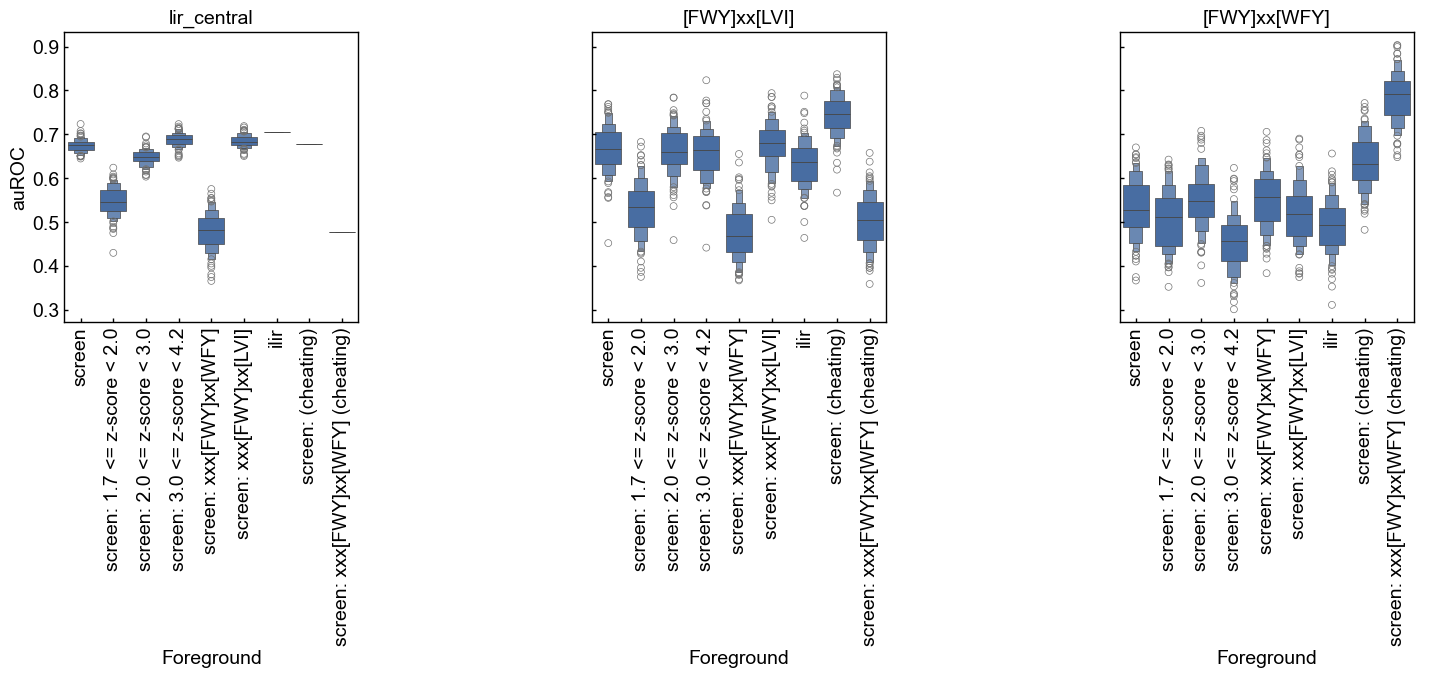

In [17]:
plot_auc_results_replicates(auc_roc_replicates_df)

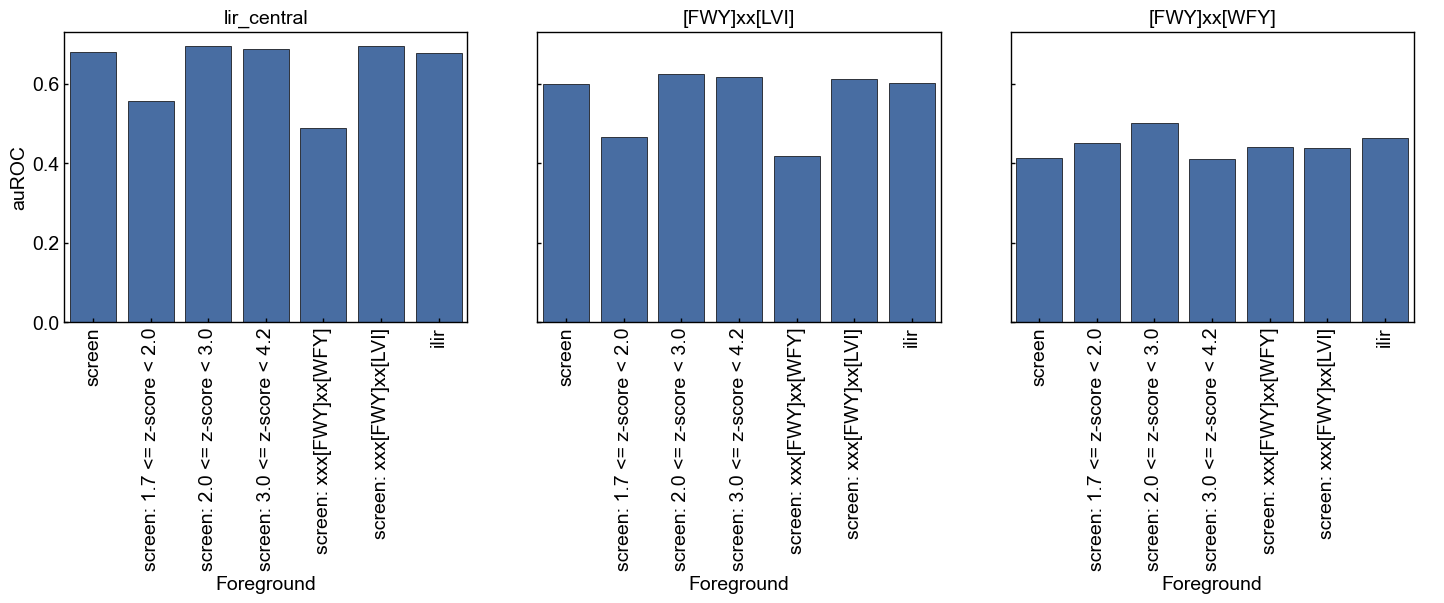

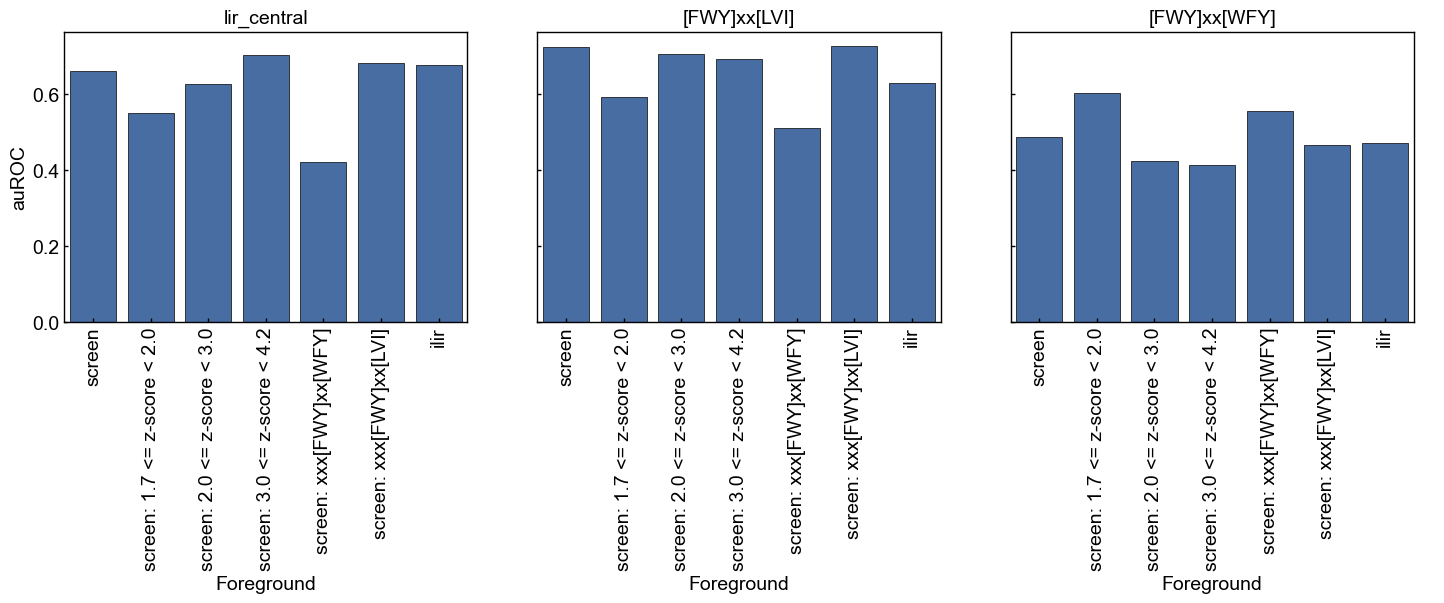

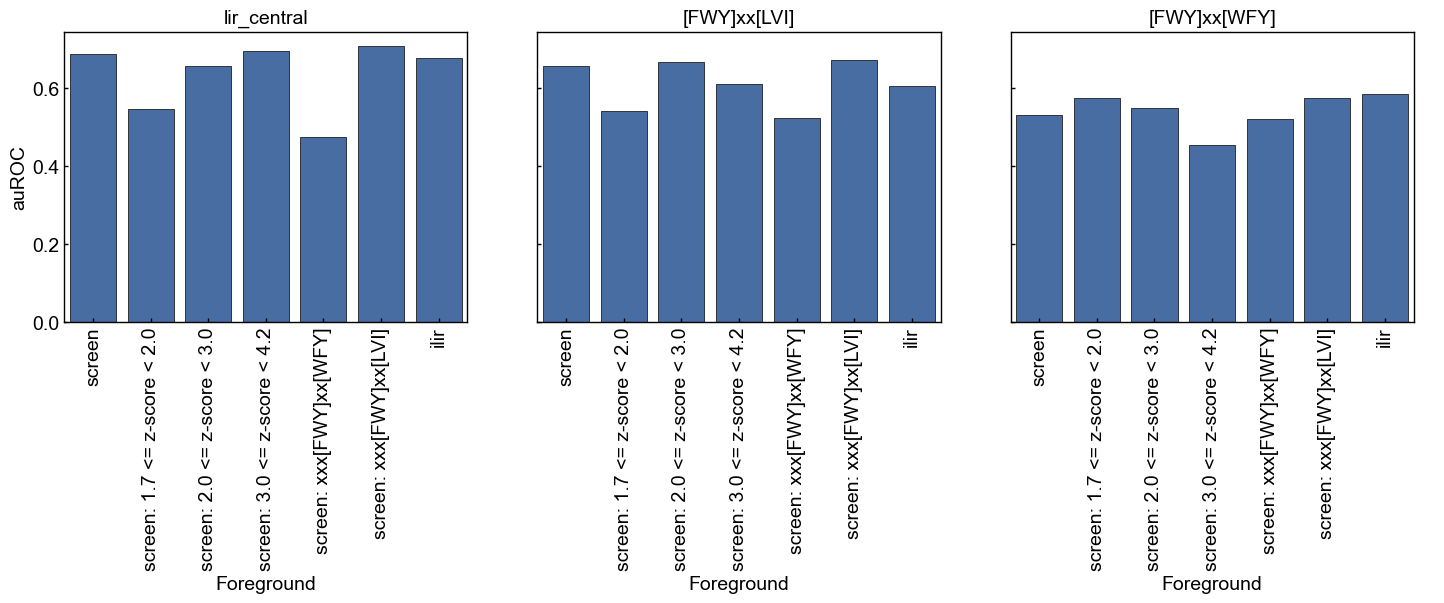

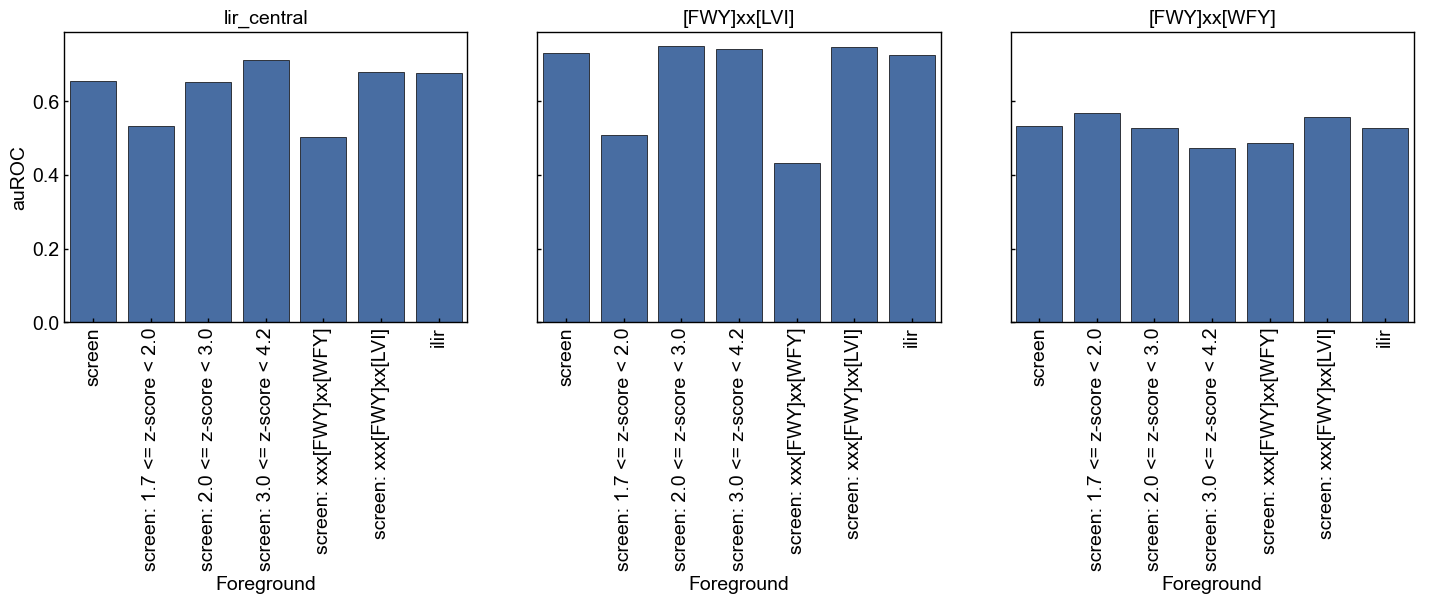

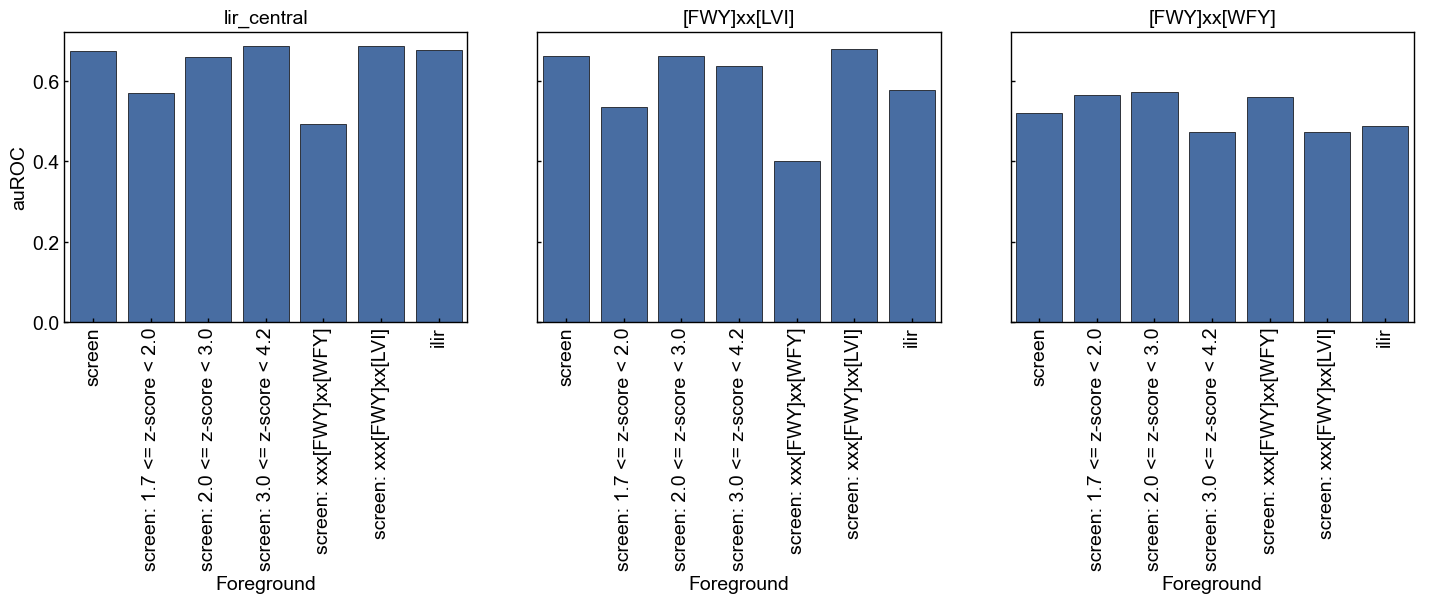

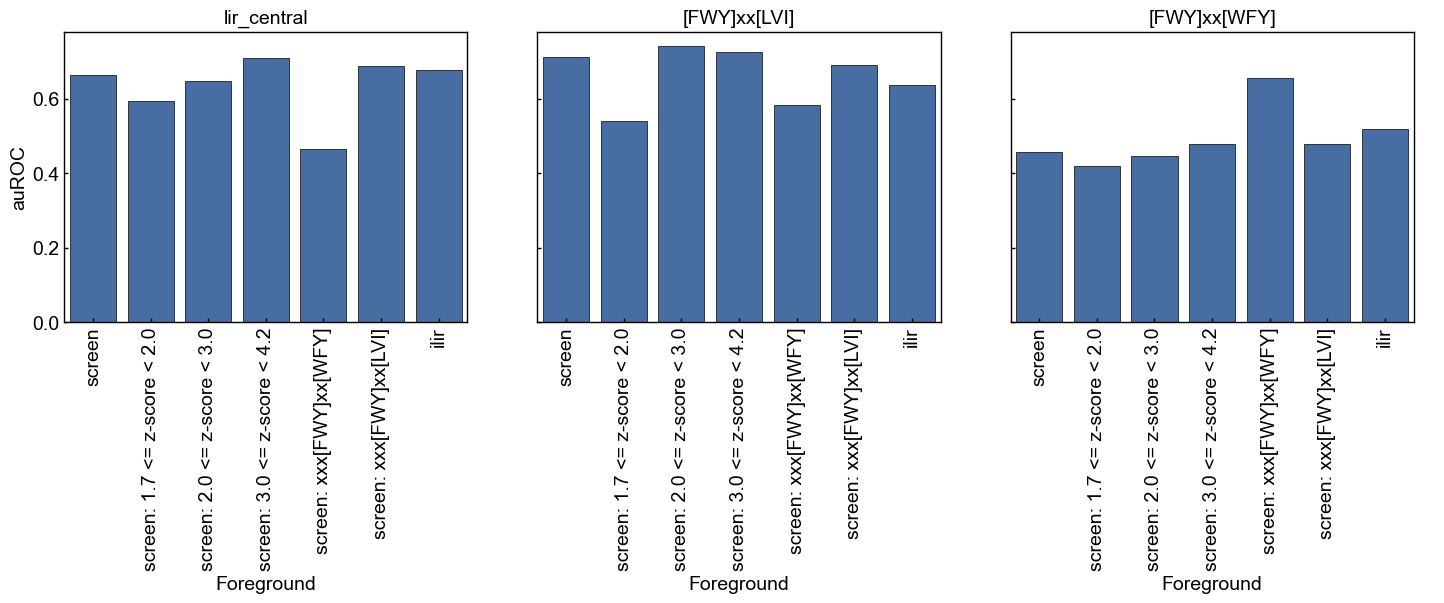

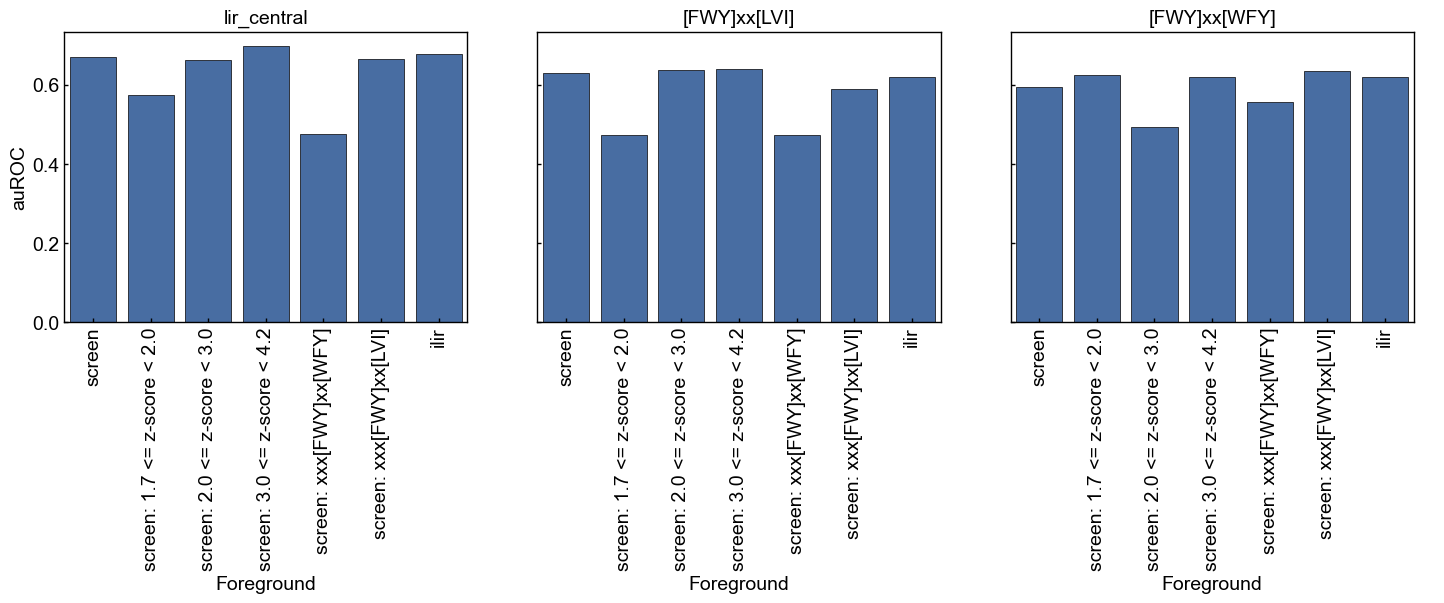

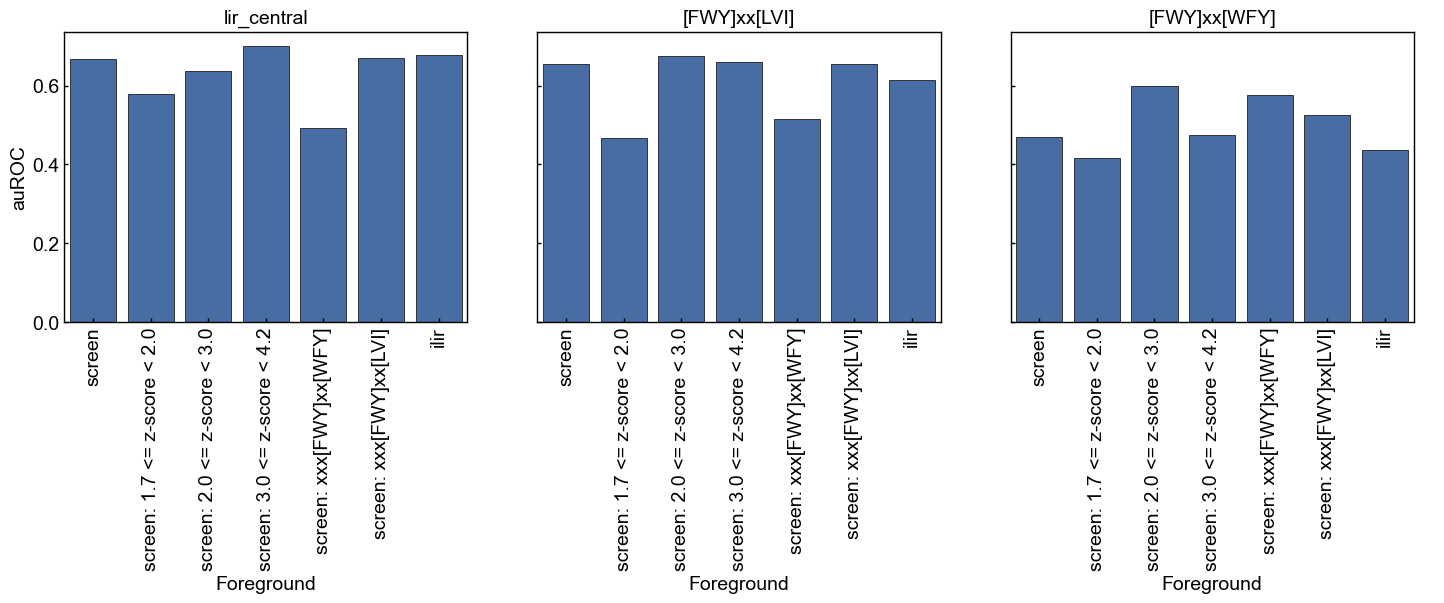

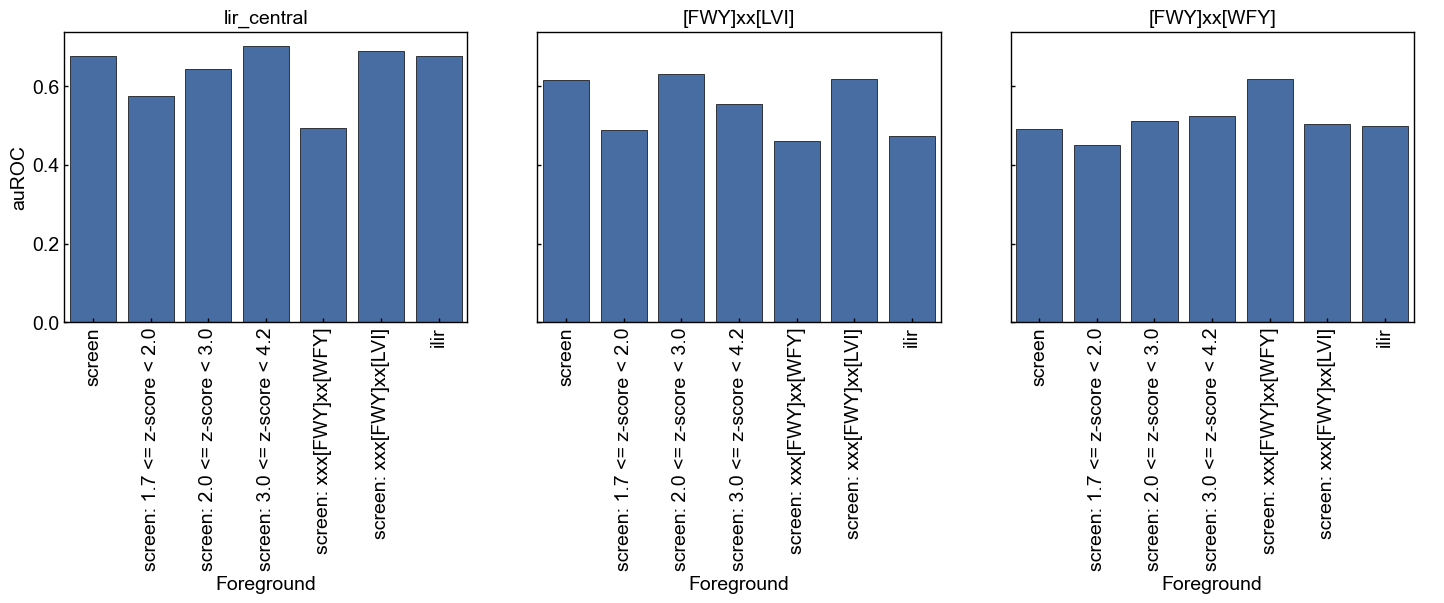

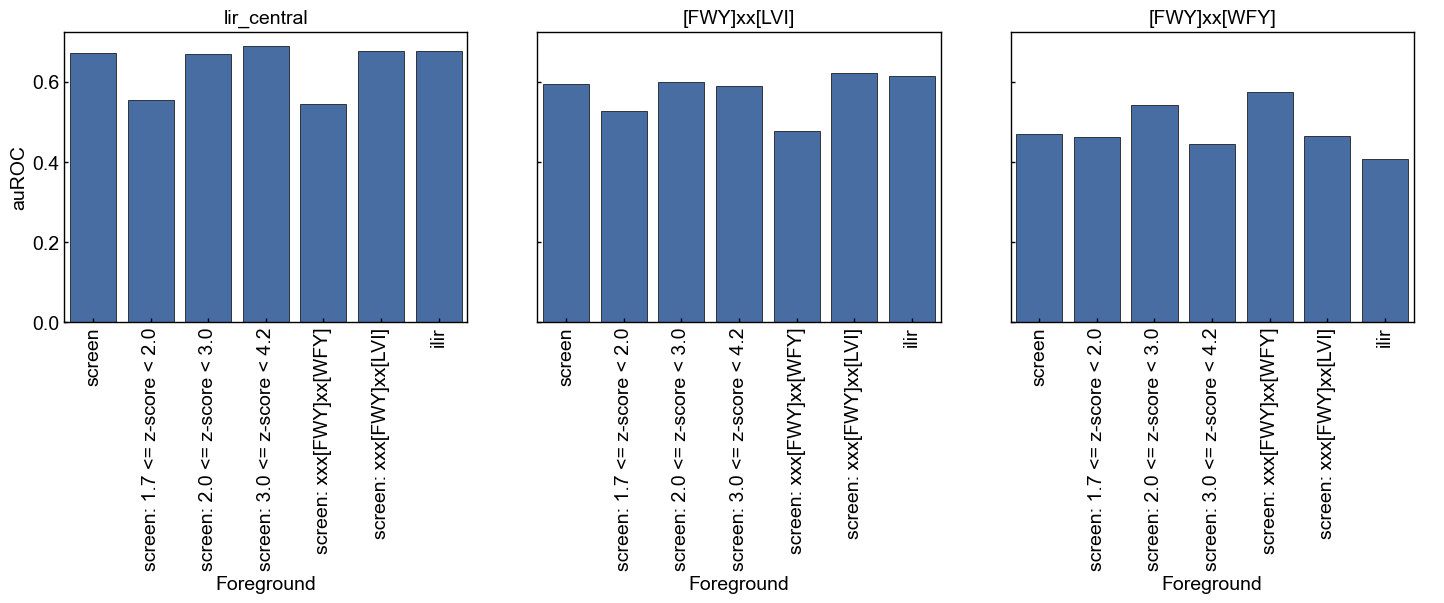

In [18]:
seed = 55
for i in range(10):
    r = PssmTestScores(*driver(
        pseudo_count=1,
        background=dl.BGFREQS.proteome,
        z_score_ranges=None,
        old_regex_test_size=40,
        new_regex_test_size=30,
        random_seed=seed,
    ))
    seed += 1
    plot_auc_results(r.auc_results)

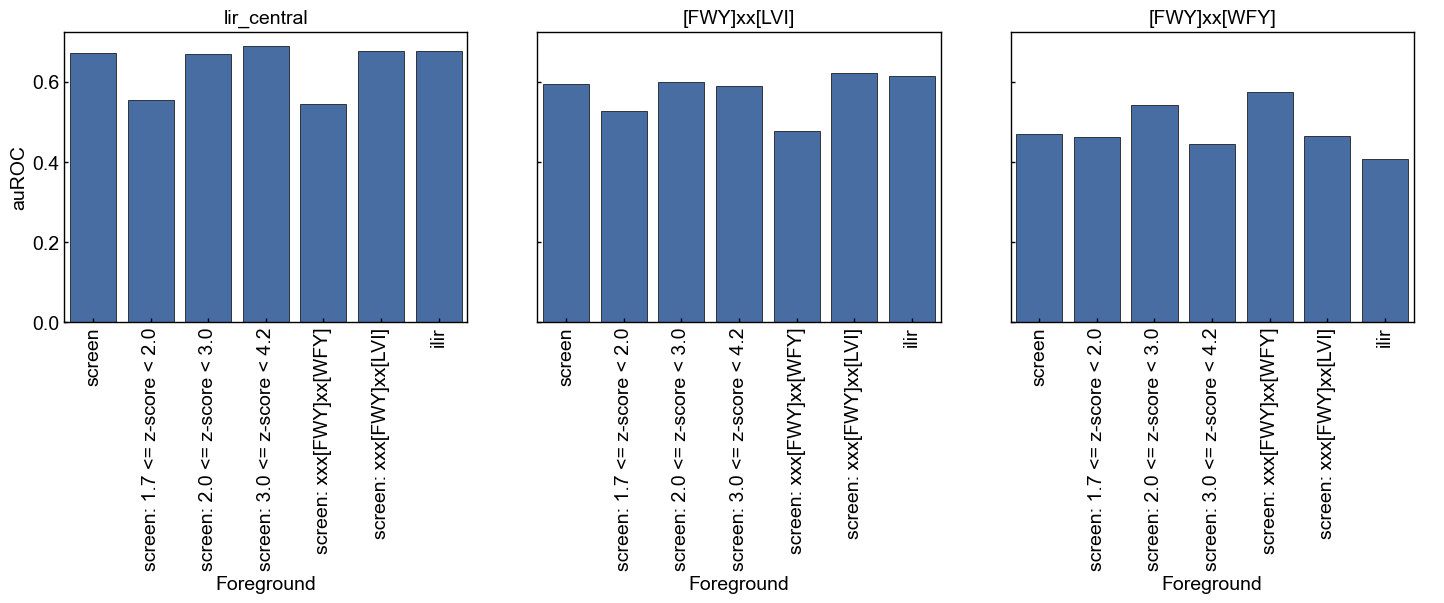

In [19]:
plot_auc_results(r.auc_results)

# what about test sets at different z-score ranges?

In [30]:
def _make_test_set_z(binders_df, nonbinders_df, test_size=50, random_seed=42):
    test_binders = binders_df.sample(
        n=test_size, random_state=random_seed, replace=False
    ).copy()
    test_nonbinders = nonbinders_df.sample(
        n=test_size, random_state=random_seed, replace=False
    ).copy()
    return pd.concat([test_binders, test_nonbinders], ignore_index=True)


def make_screen_sets_z(
    screen_binders_df: pd.DataFrame,
    screen_nonbinders_df: pd.DataFrame,
    test_size: int = 40,
    random_seed: int = 42,
):
    """
    parameters
    ----------
    screen_binders_df : pd.DataFrame
        DataFrame containing binder sequences with a column "7mer" for the 7-mer sequence.
    screen_nonbinders_df : pd.DataFrame
        DataFrame containing non-binder sequences with a column "7mer" for the 7-mer sequence.
    test_size : int
        Number of sequences to sample
    random_seed : int
        Random seed for reproducibility (default: 42).

    returns
    -------
    test_df : pd.DataFrame
        DataFrame containing the test set
    binder_training_set : pd.DataFrame
        DataFrame containing the training set for binders, excluding the test sequences
    """
    test_df = _make_test_set_z(
        screen_binders_df,
        screen_nonbinders_df,
        test_size=test_size,
        random_seed=random_seed,
    )
    test_7mers = test_df["7mer"].tolist()
    binder_training_set = screen_binders_df[
        ~screen_binders_df["7mer"].isin(test_7mers)
    ].copy()
    return test_df, binder_training_set

In [31]:
def driver2(
    pseudo_count=1,
    background=dl.BGFREQS.proteome,
    z_score_ranges=None,
    test_size=40,
    random_seed=55,
):
    if z_score_ranges is None:
        z_score_ranges = [
            [1.7, 2.0],
            [2.0, 2.5],
            [2.5, 4.2],
        ]
    test_sets = {
        "lir_central": dl.TEST_SETS.lir_central.copy(),
    }
    screen_binders = dl.PROCESSED_SEQUENCE_TABLES.screen_binders.copy()
    screen_nonbinders = dl.PROCESSED_SEQUENCE_TABLES.screen_nonbinders.copy()
    foregrounds = {
        "ilir": dl.PROCESSED_SEQUENCE_TABLES.ilir_binders["7mer"].to_list(),
        "screen": screen_binders["7mer"].to_list(),
    }
    for z_score_range in z_score_ranges:
        temp_binders_df = screen_binders[
            (screen_binders["avg_z_score"] >= z_score_range[0])
            & (screen_binders["avg_z_score"] < z_score_range[1])
        ].copy()
        test_df, screen_training = make_screen_sets_z(
            screen_binders_df=temp_binders_df,
            screen_nonbinders_df=screen_nonbinders,
            test_size=test_size,
            random_seed=random_seed,
        )
        foregrounds[f"screen: {z_score_range[0]} <= z-score < {z_score_range[1]}"] = (
            screen_training["7mer"].to_list()
        )
        test_sets[f"screen: {z_score_range[0]} <= z-score < {z_score_range[1]}"] = test_df.copy()
    for k, v in foregrounds.items():
        foregrounds[k] = pssms.seqlist_2_counts_matrix(v, pseudocount=pseudo_count)
    pssm_dict = {}
    for name, foreground in foregrounds.items():
        pssm = pssms.make_pssm(
            df_counts=foreground,
            bg=background,
        )
        pssm_dict[name] = pssm
    auc_results = score_test_sets_with_pssms(test_sets, pssm_dict)
    return test_sets, foregrounds, pssm_dict, auc_results

In [32]:
auc_roc_replicates = []
seed = 55
for i in range(100):
    r = PssmTestScores(*driver2(
        pseudo_count=0,
        background=dl.BGFREQS.proteome,
        z_score_ranges=None,
        test_size=40,
        random_seed=seed,
    ))
    seed += 1
    auc_roc_replicates.append(r.auc_results)
auc_roc_replicates_df = pd.concat(auc_roc_replicates, ignore_index=True)

In [33]:
for i in auc_roc_replicates_df["test set"].unique(): print(i)
for i in auc_roc_replicates_df["foreground"].unique(): print(i)

lir_central
screen: 1.7 <= z-score < 2.0
screen: 2.0 <= z-score < 2.5
screen: 2.5 <= z-score < 4.2
ilir
screen
screen: 1.7 <= z-score < 2.0
screen: 2.0 <= z-score < 2.5
screen: 2.5 <= z-score < 4.2


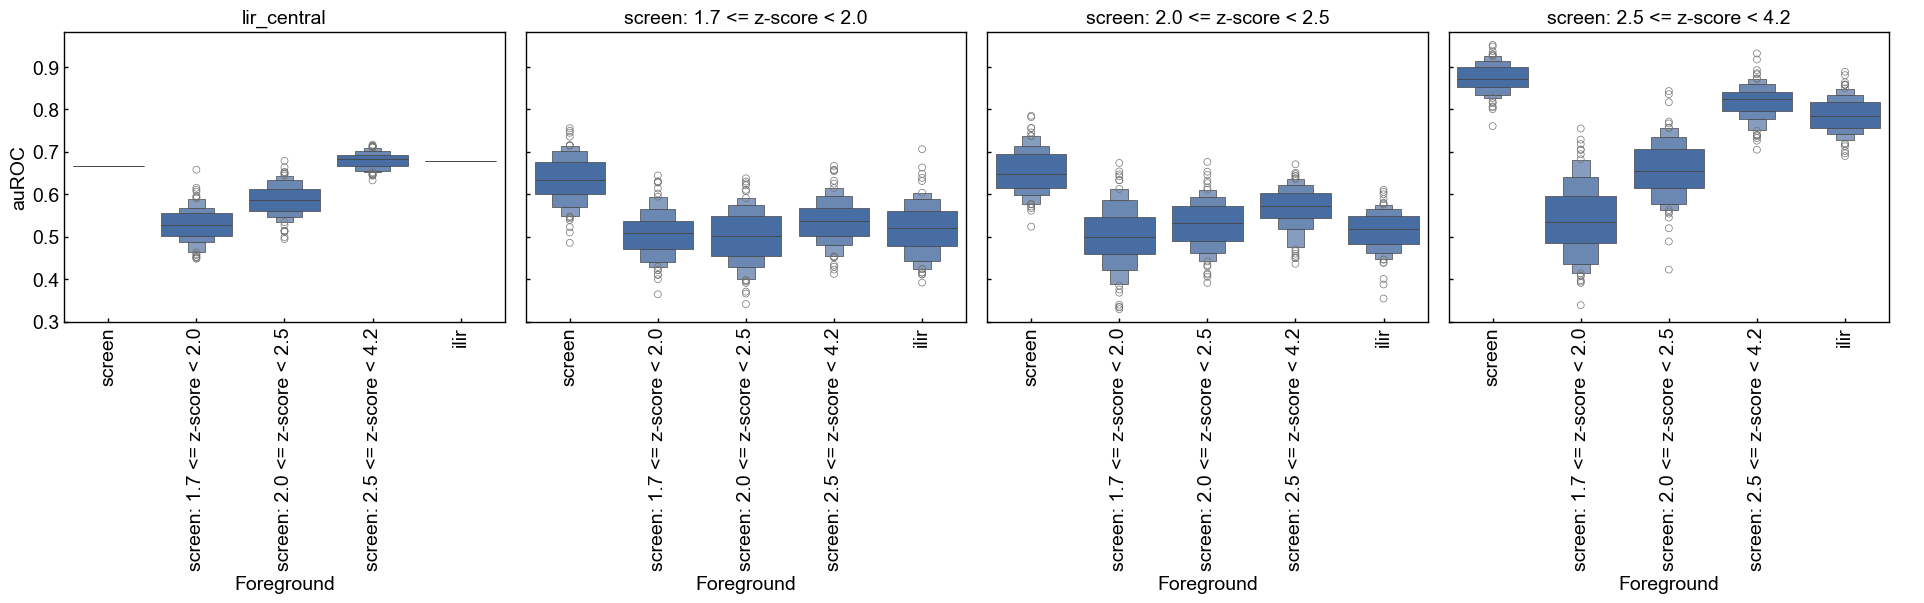

In [24]:
plot_auc_results_replicates(
    auc_roc_replicates_df,
    order=[
        "screen",
        "screen: 1.7 <= z-score < 2.0",
        "screen: 2.0 <= z-score < 2.5",
        "screen: 2.5 <= z-score < 4.2",
        "ilir",
    ]
)

In [25]:
screen_binders = dl.PROCESSED_SEQUENCE_TABLES.screen_binders.copy()
screen_binders['lir_type'].value_counts()

lir_type
...[FWY]..[LVI]    212
...[FWY]..[WFY]     66
Name: count, dtype: int64

In [26]:
pseudo_count = 1
BG = dl.BGFREQS.proteome
z_score_ranges = [
    [1.7, 2.0],
    [2.0, 3.0],
    [3.0, 4.2],
]
oldlirtest, newlirtest, screen_training = make_screen_sets(
    screen_binders_df=dl.PROCESSED_SEQUENCE_TABLES.screen_binders,
    screen_nonbinders_df=dl.PROCESSED_SEQUENCE_TABLES.screen_nonbinders,
    old_regex_test_size= 40,
    new_regex_test_size= 30,
    random_seed=55,
)
test_sets = {
    "lir_central":dl.TEST_SETS.lir_central.copy(),
    "[FWY]xx[LVI]": oldlirtest.copy(),
    "[FWY]xx[WFY]":newlirtest.copy()
}
foregrounds = {
    "ilir": dl.PROCESSED_SEQUENCE_TABLES.ilir_binders["7mer"].to_list(),
}
for z_score_range in z_score_ranges:
    temp = screen_training[
        (screen_training["avg_z_score"] >= z_score_range[0])
        & (screen_training["avg_z_score"] < z_score_range[1])
    ].copy()
    foregrounds[f"screen: {z_score_range[0]} <= z-score < {z_score_range[1]}"] = temp["7mer"].to_list()
foregrounds["screen: xxx[FWY]xx[WFY]"] = screen_training[screen_training["lir_type"]=="...[FWY]..[WFY]"]["7mer"].to_list()
foregrounds["screen: xxx[FWY]xx[LVI]"] = screen_training[screen_training["lir_type"]=="...[FWY]..[LVI]"]["7mer"].to_list()
for k, v in foregrounds.items():
    foregrounds[k] = pssms.seqlist_2_counts_matrix(v, pseudocount=pseudo_count)
pssm_dict = {}
for name, foreground in foregrounds.items():
    pssm = pssms.make_pssm(
        df_counts=foreground,
        bg=BG,
    )
    pssm_dict[name] = pssm
auc_results = score_test_sets_with_pssms(test_sets, pssm_dict)

In [27]:
screen_binders = dl.PROCESSED_SEQUENCE_TABLES.screen_binders.copy()

In [28]:
def match_regex(seq, re_pattern1, re_pattern2):
    if re.fullmatch(re_pattern1, seq):
        return re_pattern1
    elif re.fullmatch(re_pattern2, seq):
        return re_pattern2
    else:
        return np.nan

old_regex = "...[FWY]..[LVI]"
new_regex = "...[FWY]..[WFY]"
screen_binders["lir_type"] = screen_binders["7mer"].apply(
    lambda x: match_regex(x, old_regex, new_regex)
)

<Axes: xlabel='lir_type', ylabel='avg_z_score'>

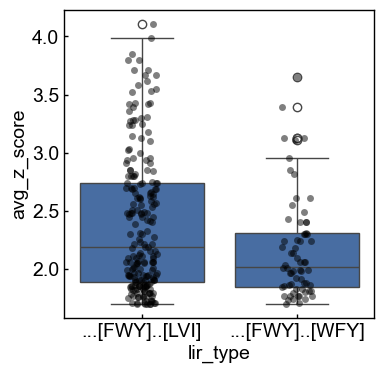

In [29]:
fig, ax = plt.subplots()
sns.stripplot(
    data=screen_binders,
    x="lir_type",
    y="avg_z_score",
    ax=ax,
    jitter=True,
    alpha=0.5,
    color="black",
)
sns.boxplot(
    data=screen_binders,
    x="lir_type",
    y="avg_z_score",
    ax=ax,
)